In [12]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import imageio
import matplotlib.cm as cm
from matplotlib import animation

Import the usual suspects

In [13]:
PITCH = 4.2
alpha = 10
beta_0 = 1.3182817e+7
coupling = 191

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [14]:
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    # print('Difference due to twist: {:.2f}'.format(beta_hel-beta_straight))
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

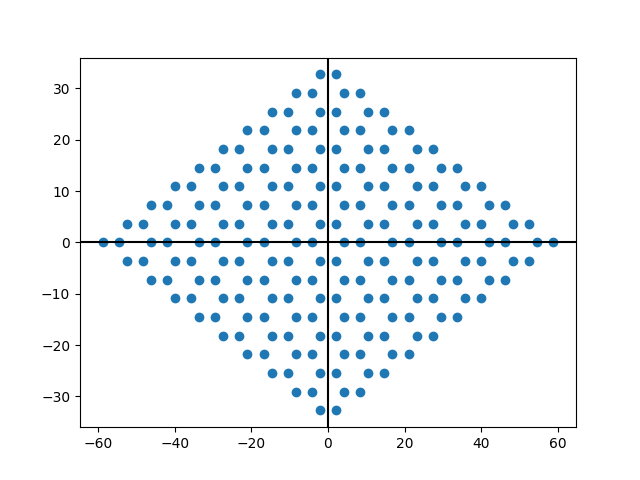

200


In [15]:
def build_honeycomb(n,m, pitch):
    a_1 = np.array([3*pitch/2, np.sqrt(3)*pitch/2])
    a_2 = np.array([3*pitch/2, -np.sqrt(3)*pitch/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-pitch, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*pitch,0])

    return centered_coord_list
b_10_list = build_honeycomb(10,10, PITCH)

plt.axhline(0, color='black')
plt.axvline(0, color='black')



plt.scatter(b_10_list[:,0], b_10_list[:,1]); 
plt.show()
print(len(b_10_list))

If we want a deformed lattice we can delete cores using the code below 

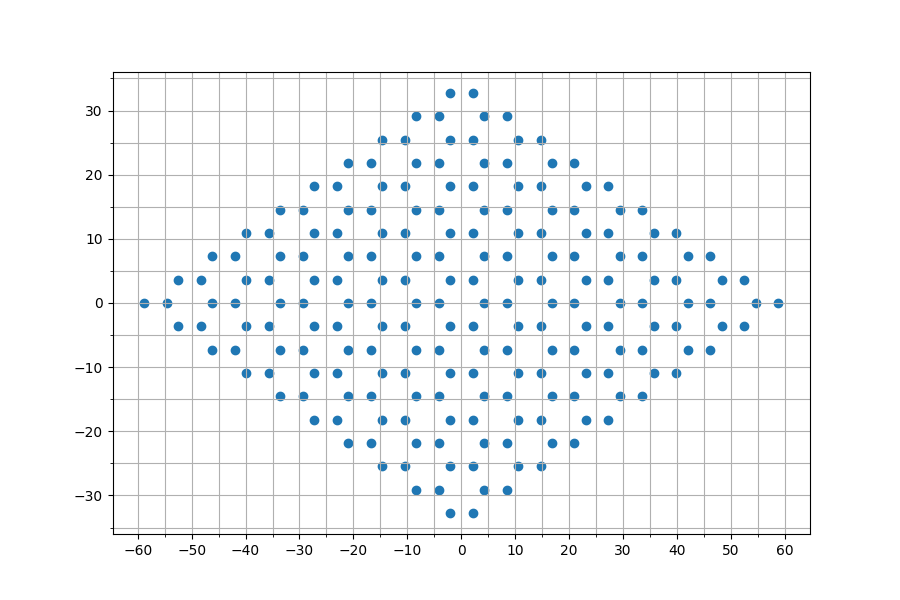

In [16]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [17]:

pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice= b_10_list[index_to_keep]
# [print(type(i)) for i in pos]
# print(pos)

ValueError: XB must be a 2-dimensional array.

200


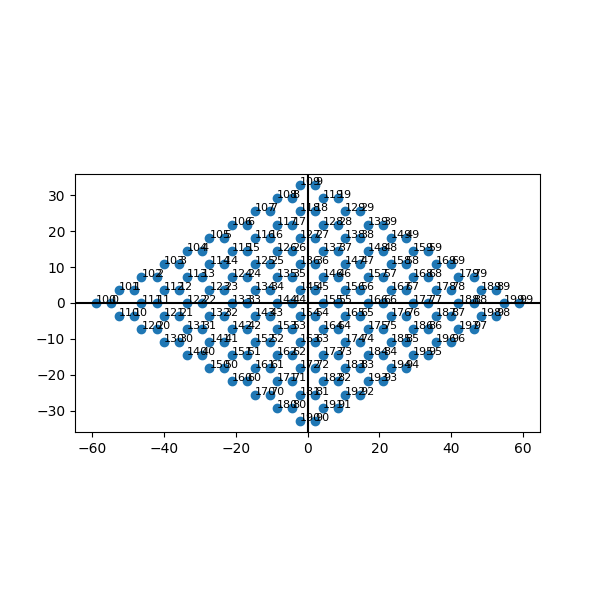

In [18]:
fig_deformed_lattice_plot = plt.figure(figsize=(6,6))
ax_deformed_lattice_plot = fig_deformed_lattice_plot.add_subplot(111)
ax_deformed_lattice_plot.axhline(0, color='black')
ax_deformed_lattice_plot.axvline(0, color='black')
ax_deformed_lattice_plot.scatter(b_10_list[:,0], b_10_list[:,1])
ax_deformed_lattice_plot.set_aspect('equal')
for i in range(len(b_10_list)):
    # print(i, coord)
    ax_deformed_lattice_plot.annotate(str(i), (b_10_list[i,0], b_10_list[i,1]), fontsize=8)
print(len(b_10_list))

plt.show()

Now we want to read in a geometry from COMSOL and find the nearest neighbours

In [19]:

# coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/honeycomb coord locs small.csv', header=4,float_precision='round_trip')
# # coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/coupled_core_locs.csv', header=4,float_precision='round_trip')

# #display(coord_data.iloc[:,1:])
# x_coords = coord_data.iloc[:,1:128]
# y_coords = coord_data.iloc[:,128:]
# x_coord_np = x_coords.transpose()[0].to_numpy()
# y_coord_np = y_coords.transpose()[0].to_numpy()

# combined_list  = np.transpose(np.array((x_coord_np,y_coord_np)))


def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

Next we build up the vector potential $\mathbf{A}(\mathbf{r})$

In [20]:
def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A


Finally we stick all of these components into our coupling matrix C

In [21]:
def find_eigvalues(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return beta_super,eigvecs


In [22]:
# Plotting betas
def plot_betas(beta_vals, coupling, point_label, xrange=[]):
    fig1  = plt.figure(figsize=(7,7))   
    ax1 = fig1.add_subplot(111)
    if type(beta_vals) == list:
        for i,vals in enumerate(beta_vals):
            ax1.scatter(np.arange(len(vals)), vals, label=point_label[i])

    else: 
        ax1.scatter(np.arange(len(beta_vals)), beta_vals-np.mean(beta_vals), label=point_label)
    ax1.grid(axis='x', which='both')
    ax1.set_ylabel(r'$ \beta$')
    ax1.set_xlabel('Mode Index')
    if len(xrange) == 2:
        ax1.set_xlim(xrange[0],xrange[1])
    plt.legend();
    # fig1.savefig('../Twisted Fibre/Figures/twisted_fibre_betas_with_onsite.svg', dpi=300)


In [23]:
# For nice plotting of eigenvectors 
def plot_coloured_chain(intensities, circ_size, circ_locations, label, ):
    """
    
    """
    fig_chain = plt.figure(figsize=(5,5))
    ax_chain = fig_chain.add_subplot(111)
    intensities = intensities/np.sum(intensities)
    circ_list = []
    norm = colors.Normalize(vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        #print(intensities[j])
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 

#         ax_chain.annotate(str(j), (circ_locations[j][0], circ_locations[j][1]), color='black',
#                           fontsize=10, ha='center', va='center')
   
    # plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    plt.show()     
    return  



In [24]:
beta_vals_1, beta_vecs_1 = find_eigvalues(b_10_list, 4.2, 6700, 5876619.5, 1200, with_onsite=True)

We now have $i \frac{\partial \mathbf{a}}{\partial z} = C \mathbf{a}$ 
where $\mathbf{a}$ is a vector of complex amplitudes describing the contribution of each single core mode to each supermode k

$\beta \mathbf{a} = C \mathbf{a}$

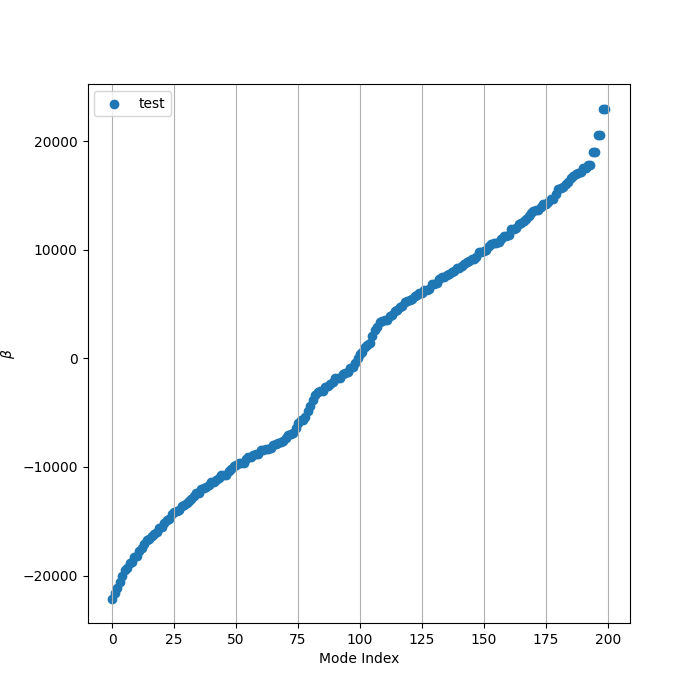

In [25]:
plot_betas(beta_vals_1, 6700,'test')

Now let's look at some of the eigenmodes 

No on-site term with low twist

In [26]:
# vec_intensities = np.conjugate(beta_vecs_1)*beta_vecs_1
# for i in range(77,91):
#     plot_coloured_chain(vec_intensities[:,i], 4, deformed_lattice,i)

In [27]:
def calc_supermode(length, betas, eigenvectors, beta_0, input_vec):
    propagation_constants = betas + beta_0

    normalised_eigenvectors = eigenvectors / np.sqrt(np.einsum('i...,i...->...', np.conjugate(eigenvectors), eigenvectors))

    b_vec = np.einsum('i...,i...->...',  np.conjugate(normalised_eigenvectors), input_vec)
    # print(b_vec)
    
    psi_mat = b_vec * normalised_eigenvectors * np.exp(1.0j * propagation_constants * length)

    psi = np.sum(psi_mat, axis=1)
    # print(np.argmax(psi))
    intensities = (psi*np.conjugate(psi)) /np.sum(psi*np.conjugate(psi))

    return intensities

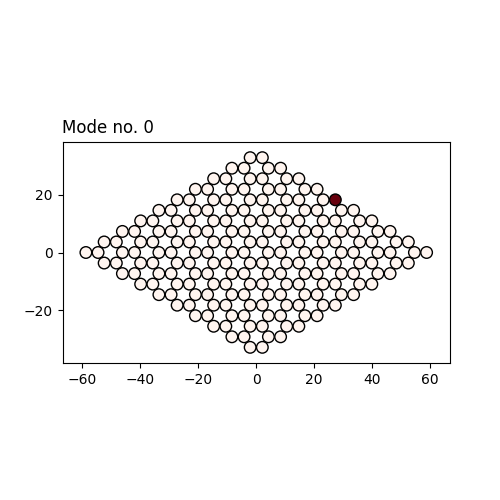

<ipython-input-28-27641a9d8e10>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  intensity_to_plot[:,n] = intensities_at_distance


In [28]:
exciting_edge = np.zeros(len(beta_vals_1))
exciting_edge[49] = 1.0
plot_coloured_chain(exciting_edge, 4, b_10_list,0)
# print(beta_vecs_1[:,3]/np.sqrt(np.vdot(beta_vecs_1[:,3],beta_vecs_1[:,3])))
zrange = 0.10
zpoints = 500
intensity_to_plot = np.zeros((len(beta_vals_1), zpoints))
for n,i in enumerate(np.linspace(0,zrange, zpoints)):
    intensities_at_distance = calc_supermode(i, beta_vals_1, beta_vecs_1, 5876619, exciting_edge)
    intensity_to_plot[:,n] = intensities_at_distance

In [29]:
name_list = []
for i in range(np.shape(intensity_to_plot)[1]):
    fig_chain = plt.figure(figsize=(6,6))
    ax_chain = fig_chain.add_subplot(111)

    circ_list = []
    norm = colors.Normalize(vmin=min(np.real(intensity_to_plot[:,i])), vmax=max(np.real(intensity_to_plot[:,i])))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensity_to_plot)))
    for j in range(len(intensity_to_plot)):
        circ_list.append(patches.Circle((b_10_list[j][0], b_10_list[j][1]), radius=4//2,
                                            color=cmap(norm(np.real(intensity_to_plot[j,i]))),ec='black')) 

    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)

    plt.axis('scaled')

    plot_name = r'C:/Users/nr421/Documents/Twisted gifs/individual images/twisted propagation plot {:.1f}.png'.format(i)
    name_list.append(plot_name)
    fig_chain.savefig(plot_name)
    plt.close()
# name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
with imageio.get_writer('C:/Users/nr421/Documents/Twisted gifs/small 1200 twist with onsite 10cm edge.gif', mode='I', duration=0.1, loop=0) as writer:
    for filename in name_list:
        image = imageio.imread(filename)
        writer.append_data(image)
writer.close()


TypeError: get_writer() missing 1 required positional argument: 'uri'

In [ ]:
two_coupled_core_vals, two_coupled_core_vecs = np.linalg.eigh(np.array([[0,50],[50,0]]))
excite_one = np.array([0,1])
plot_coloured_chain(excite_one, 4, np.array([[-2,0],[2,0]]),0)
# for i in np.linspace(0,0.02,10):
#     both_excited= calc_supermode(i, two_coupled_core_vals, two_coupled_core_vecs, 0, excite_one)
#     plot_coloured_chain(both_excited, 4, np.array([[-2,0],[2,0]]),0 )
#     print(both_excited)

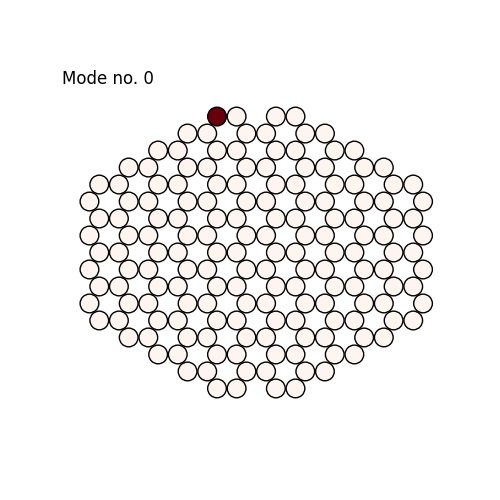

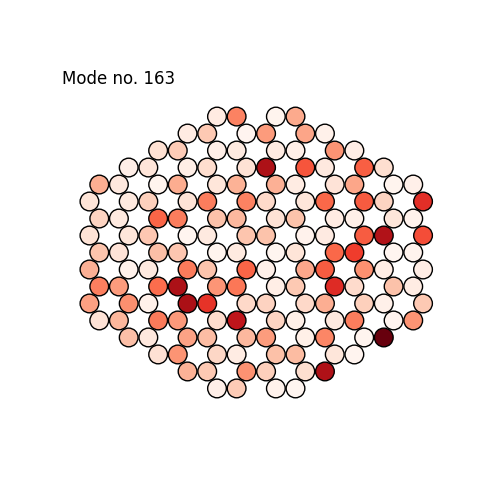

In [57]:
plot_coloured_chain(exciting_edge, 4, deformed_lattice,0)

plot_coloured_chain(intensities_at_distance, 4, deformed_lattice,i)



In [38]:
def plot_coloured_chain_gif(intensities, circ_size, circ_locations, save_as):
    """
    """
    name_list = []
    for i in range(np.shape(intensities)[1]):
        fig_chain = plt.figure(figsize=(12,10))
        ax_chain = fig_chain.add_subplot(111)

        circ_list = []
        norm = colors.Normalize(vmin=min(np.real(intensities[:,i])), vmax=max(np.real(intensities[:,i])))
        cmap = plt.cm.get_cmap('Greys_r').reversed()
        cmap(norm(np.real(intensities[:,i])))

        for j in range(len(intensities)):
            circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                                color=cmap(np.real(intensities[j,i])),ec='black')) 

        plt.axis('off')
        # Plot all circles
        for _circ in circ_list:
            ax_chain.add_patch(_circ)

        plt.axis('scaled')

        plot_name = 'winding_numbers/numerical_propagation/comsol_gif/SSH chain intensities step {:.2f}.png'.format(i)
        name_list.append(plot_name)
        fig_chain.savefig(plot_name)
        plt.close()
    name_list = [val for val in name_list for _ in range(2)] # This just takes images multiple times to slow down the gif
    with imageio.get_writer('winding_numbers/numerical_propagation/comsol_gif/'+save_as+'.gif', mode='I') as writer:
        for filename in name_list:
            image = imageio.imread(filename)
            writer.append_data(image)
    return 

In [ ]:
def plot_propagation_as_gif(z_list, evals, evecs, input_vec, circle_locations, file_out_name):
    
    mode_intensities = np.zeros([len(evals),len(z_list)],dtype=complex)
    for j,z in enumerate(z_list):
        mode_intensities[:,j] = propagator(z, evals, evecs, input_vec)
    
    

    #plot_coloured_chain_gif(mode_intensities,3,circle_locations,file_out_name)
    
    return mode_intensities